# Import Packages

In [46]:
!pip install torchsummary

In [47]:
import pydicom
import pandas as pd
import numpy as np
import random
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

# Configuration

In [48]:
class config:
    
    root = ""
    valid_prob = 0.2
    batch_size = 16
    lr = 1e-4
    epochs = 150
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


# Input Data

In [49]:
train_data = pd.read_csv(config.root+'/data/train.csv')
test_data = pd.read_csv(config.root+'/data/test.csv')
print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [50]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

# Defined functions

In [108]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, ages, genders, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        ages = ages.to(device=device, dtype=torch.float)
        genders = genders.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1

def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1


def predict(model, test_loader, device):
    model.eval()
    model.to(device)
    prob = []
    predictions = []
    with torch.no_grad():
        for images, ages, genders in test_loader:
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            
            logits = model(images, ages, genders)
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            prob.append(logits)


        predictions = torch.cat(predictions)
    return predictions,  prob

# Defined Dataset

In [87]:
class ParkinsonsDataset(Dataset):
    def __init__(self, df, transforms = None, mode = "train"): # 將所有資料提出
        self.df = df
        self.mode = mode
        self.ages = np.array(df['Age']) # 年齡
        self.genders = np.array(df['Gender']) # 性別
        if self.mode != "test":
            self.labels = np.array(df['Stage']) # 標籤
        self.indexs = np.array(df['index']) # 起始張數
        self.paths = np.array(df['FilePath']) # 影像路徑
        self.images = []

        # 影像前處理
        for index, path in zip(self.indexs, self.paths):
            image = pydicom.dcmread(config.root+'/data'+path).pixel_array
            image = torch.tensor(image.astype(np.float32))
            image = image[index-1:index+2, :, :] # 取指定張數和前後共三個, image size = (3, 128, 128)
            if transforms:
                image = transforms(image)
            self.images.append(image)


    def __len__(self):
        return self.df.shape[0] # label數量

    def __getitem__(self, idx): # 找出指定的資料
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        
        
        image = self.images[idx]
        if self.mode == "test":
            return image, age, gender
        else:
            label = self.labels[idx]
            return image, age, gender, label

# Transformation
class My_normalize(object): # 自定義的類別
    # def __init__(self): # 宣告此類別中會使用到的變數

    def __call__(self, image): # 定義有image之後要進行的資料處理
        new_image = (image - image.mean())/(image.max() - image.min())

        return new_image

My_transforms = v2.Compose([
    # 在v2中內建的func
    v2.CenterCrop(size = (50, 50)),
    # 自定義的func
    My_normalize()
])

# Redefined ResNet50

In [53]:
class ResNet50plus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), out_prob = True, features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 決定是否要將輸出轉換為機率
        self.out_prob = out_prob
        
        resnet50 = models.resnet50(weights='IMAGENET1K_V1', progress = True)
        resnet50.fc = nn.Identity()
        resnet50.avgpool = nn.AdaptiveAvgPool2d(1)
        
        
        # 固定/不固定特徵層的參數值
        for param in resnet50.parameters():
            param.requires_grad = features_grad
        self.backend = resnet50
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(2048+2, num_classes) # 512: vgg16特徵層結果, 2: age & gender
        )
        self.softmax = nn.Softmax(dim=1) # 每一個row的總和都是1

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3)
        if self.out_prob:
            outputs = self.softmax(outputs)
        return outputs

# Redefined VGG16

In [54]:
class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), out_prob = True, features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 決定是否要將輸出轉換為機率
        self.out_prob = out_prob
        
        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
        vgg16.features[30] = nn.Identity()
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(514, num_classes) # 512: vgg16特徵層結果, 2: age & gender
        )
        self.softmax = nn.Softmax(dim=1) # 每一個row的總和都是1

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3)
        if self.out_prob:
            outputs = self.softmax(outputs)
        return outputs

In [55]:
model = VGGplus(num_classes = 3)
print(model)
del model

VGGplus(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

### 1. 導入 vgg16 的架構和 ImageNet 訓練出來的權重 (**transfer learning**)

In [56]:
vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

以下簡單介紹vgg16中使用到的函式: (以下函式的輸入都需要四個維度: (N = number of data, C = number of channels, H = Height, W = Width))

> [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

> * 3: in_channels
> * 64: out_channels 
> * stride = (1, 1): kernel的移動由左至右, 由上至下, 步長皆為1
> * padding = (1, 1): 在輸入的周圍填充一層0

> Note:
> * 雖然是2d的convolution, 但實際的輸入是和kernel都是3維陣列, 而2d指的是kernel移動的方向。
> * 因為1個(3, 3, 3)的kernel和1個bias遍歷一次輸入就會產生一層輸出, 這邊的輸出有64層, 就需要64個(3, 3, 3)的kernal和對應的64個bias。
> * 這樣的stride和padding的設定可以讓輸出和輸入的長寬不變。

![](https://discuss.pytorch.org/uploads/default/original/3X/6/0/60994f2ed1f8c34ee6e83741e2e87fca0a1b4655.jpeg)

In [57]:
m = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
print(m)
input = torch.randn(1, 3, 50, 50)
print(input.shape)
output = m(input)
print(output.shape)
for param in m.parameters():
    print(param.shape)
    
del m, input, output

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 3, 50, 50])
torch.Size([1, 64, 50, 50])
torch.Size([64, 3, 3, 3])
torch.Size([64])


> [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

> * ceil_mode: True = 將不足的邊用NAN補齊, False = 將不足的邊直接刪除

In [58]:
input = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3]]).reshape(1, 1, 3, 3).float()
print(input)

print("ceil_mode = False")
m1 = nn.MaxPool2d(2, stride=2, ceil_mode = False)
output1 = m1(input)
print(output1)

print("ceil_mode = True")
m2 = nn.MaxPool2d(2, stride=2, ceil_mode = True)
output2 = m2(input)
print(output2)

del m1, m2, input, output1, output2

tensor([[[[1., 1., 1.],
          [2., 2., 2.],
          [3., 3., 3.]]]])
ceil_mode = False
tensor([[[[2.]]]])
ceil_mode = True
tensor([[[[2., 2.],
          [3., 3.]]]])


> [AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)(output_size=(7, 7)) 

> 按照期望的輸出大小對輸入做平均

In [59]:
input = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3]]).reshape(1, 1, 3, 3).float()
print(input)

m7 = nn.AdaptiveAvgPool2d(output_size=(7, 7))
output = m7(input)
print(output)

m2 = nn.AdaptiveAvgPool2d(output_size=(2, 2))
output = m2(input)
print(output)

del input, m7, m2, output

tensor([[[[1., 1., 1.],
          [2., 2., 2.],
          [3., 3., 3.]]]])
tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
          [2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000],
          [2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000],
          [3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000],
          [3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000]]]])
tensor([[[[1.5000, 1.5000],
          [2.5000, 2.5000]]]])


雖然AdaptiveAvgPool2d()的輸出大小可以大於輸入大小，但這種作法可能導致訊息的丟失。

### 2. 觀察 vgg16 的 Output Shape 去設計 feature layers 和 classifier layers 之間的連接層

In [60]:
# 因summary()的input存在GPU中, 要將model也移至GPU上才能運行
vgg16.to(config.device)
summary(vgg16, input_size = (3, 50, 50)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
              ReLU-2           [-1, 64, 50, 50]               0
            Conv2d-3           [-1, 64, 50, 50]          36,928
              ReLU-4           [-1, 64, 50, 50]               0
         MaxPool2d-5           [-1, 64, 25, 25]               0
            Conv2d-6          [-1, 128, 25, 25]          73,856
              ReLU-7          [-1, 128, 25, 25]               0
            Conv2d-8          [-1, 128, 25, 25]         147,584
              ReLU-9          [-1, 128, 25, 25]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

在ReLU-30得到的輸出大小已經是(512, 3, 3), 如果使用模型中的MaxPool2d-31:MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, **ceil_mode=False**), 會有些資訊被忽略, 所以接下來會更改31層和32層。

In [61]:
vgg16.features[30] = nn.Identity()
vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
vgg16.classifier = nn.Identity()
summary(vgg16, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
              ReLU-2           [-1, 64, 50, 50]               0
            Conv2d-3           [-1, 64, 50, 50]          36,928
              ReLU-4           [-1, 64, 50, 50]               0
         MaxPool2d-5           [-1, 64, 25, 25]               0
            Conv2d-6          [-1, 128, 25, 25]          73,856
              ReLU-7          [-1, 128, 25, 25]               0
            Conv2d-8          [-1, 128, 25, 25]         147,584
              ReLU-9          [-1, 128, 25, 25]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

Note: 
* 在avgpool和classifier之間, vgg16模型會把(-1, 512, 1, 1)reshape成(-1, 512)。
* 每一個(3, 50, 50)的影像經過更改後的vgg16模型就會產生512個數值。

### 3. 增加影像之外的變數(ex. 性別, 年齡, ...)去建立 classifier layers

這裡想建立一個特徵層可以考慮剛剛影像經過特徵層所得到的512個數值和性別, 年齡這兩個數值, 所以分類層的一開始會有512+2 = 514個神經元。

In [62]:
del vgg16

****************************** Using vgg16 to train ******************************
Initializing dataset...
Initializing test_dataset...
Number of samples in train_dataset: Counter({3: 60, 2: 35, 1: 34})
Number of samples in val_dataset: Counter({3: 15, 1: 10, 2: 7})
Initializing model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s] 


Fold[1/5],Epoch[1/150], Train Loss: 1.0896, Train Accuracy: 35.16%, Train F1: 25.83% | Valid Loss: 1.0534, Valid Accuracy: 54.55%, Valid F1: 40.89% | LR: 0.000004
Fold[1/5],Epoch[2/150], Train Loss: 1.0775, Train Accuracy: 53.12%, Train F1: 37.30% | Valid Loss: 1.0303, Valid Accuracy: 45.45%, Valid F1: 21.28% | LR: 0.000004
Fold[1/5],Epoch[3/150], Train Loss: 1.0663, Train Accuracy: 48.44%, Train F1: 25.21% | Valid Loss: 1.0088, Valid Accuracy: 45.45%, Valid F1: 20.83% | LR: 0.000005
Fold[1/5],Epoch[4/150], Train Loss: 1.0549, Train Accuracy: 47.66%, Train F1: 23.30% | Valid Loss: 0.9828, Valid Accuracy: 45.45%, Valid F1: 20.83% | LR: 0.000006
Fold[1/5],Epoch[5/150], Train Loss: 1.0416, Train Accuracy: 46.88%, Train F1: 21.28% | Valid Loss: 0.9524, Valid Accuracy: 45.45%, Valid F1: 20.83% | LR: 0.000007
Fold[1/5],Epoch[6/150], Train Loss: 1.0289, Train Accuracy: 46.88%, Train F1: 21.28% | Valid Loss: 0.9188, Valid Accuracy: 45.45%, Valid F1: 20.83% | LR: 0.000008
Fold[1/5],Epoch[7/150]

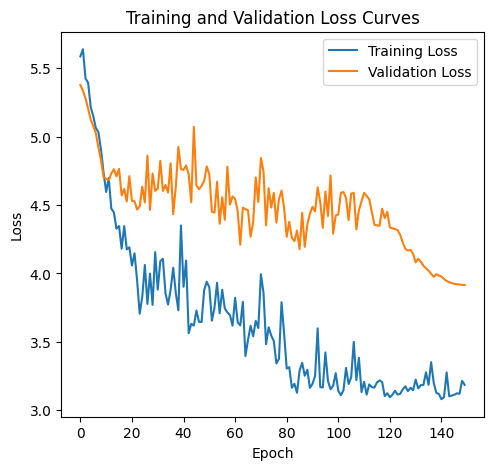

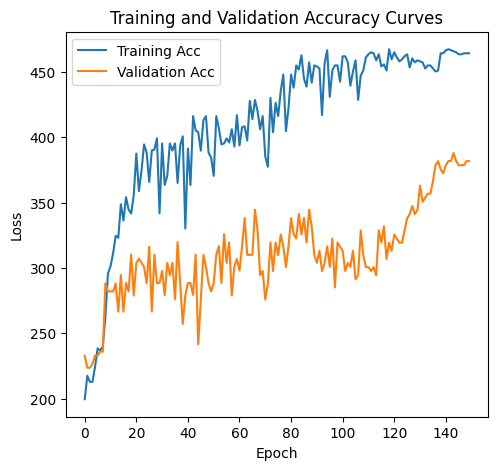

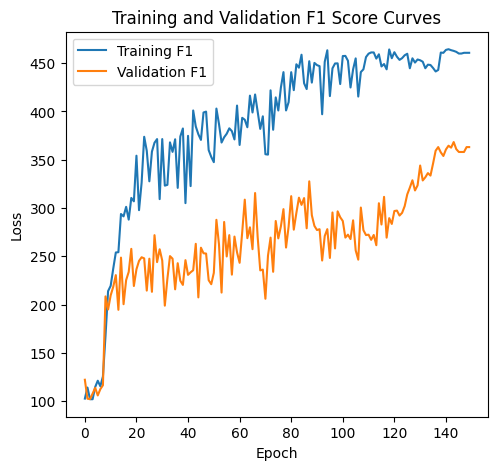

In [63]:
def main(model_name):
    
    print(f"****************************** Using {model_name} to train ******************************")
    seed_everything(config.seed)

    # train & test dataframe
    train_df = pd.read_csv(config.root+'/data/train.csv')
    test_df = pd.read_csv(config.root+'/data/test.csv')

    # Dataset
    print("Initializing dataset...")
    dataset = ParkinsonsDataset(train_df, transforms = My_transforms)
    print("Initializing test_dataset...")
    test_dataset = ParkinsonsDataset(test_df, transforms = My_transforms)
    
    # split training & validation dataset 
    n = len(dataset)
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    print(f'Number of samples in train_dataset: {Counter(dataset.labels[train_ids])}')
    print(f'Number of samples in val_dataset: {Counter(dataset.labels[valid_ids])}')
    
    # recordings
    
    history = {
      "train": {
          "loss": [0]*config.epochs,
          "acc": [0]*config.epochs,
          "f1": [0]*config.epochs
      },
      "valid": {
          "loss": [0]*config.epochs,
          "acc": [0]*config.epochs,
          "f1": [0]*config.epochs
      },
    }
    
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
        # DataLoader
        train_dataset = Subset(dataset, train_ids)
        valid_dataset = Subset(dataset, valid_ids)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

        # settings
        print("Initializing model...")
        num_classes = len(Counter(dataset.labels[train_ids]))
        models = {
            "vgg16": VGGplus(num_classes = num_classes, features_grad = True),
            "resnet50": ResNet50plus(num_classes = num_classes, features_grad = True)
        }
#         model = VGGplus(num_classes = num_classes, features_grad = True)
        model = models[model_name]
        model.to(config.device)
        criterion = nn.CrossEntropyLoss().to(config.device)
        optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer = optimizer,
            epochs = config.epochs,
            steps_per_epoch = train_loader.__len__(),
            max_lr = config.lr,
            anneal_strategy = 'cos'
        )
        
        best_val_loss = float("inf")
        for epoch in range(config.epochs):
            train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
            valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)

            # Log the loss and validation result
            history["train"]["loss"][epoch] += train_loss
            history["train"]["acc"][epoch] += train_acc
            history["train"]["f1"][epoch] += train_f1
            history["valid"]["loss"][epoch] += valid_loss
            history["valid"]["acc"][epoch] += valid_acc
            history["valid"]["f1"][epoch] += valid_f1

#             print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
            print(f'Fold[{fold+1}/{k_folds}],Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')


            if valid_loss < best_val_loss:
                save_file = {
                    "accuracy": valid_acc,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
#                     "scheduler": scheduler.state_dict(),
                    "epoch": epoch,
                    "args": config
                }
                best_val_loss = valid_loss
                torch.save(save_file, f"/kaggle/working/{model_name}_{fold}_checkpoint.pth")

            best_ckpt = torch.load(f"{model_name}_{fold}_checkpoint.pth", map_location=config.device)
            model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main("vgg16")

****************************** Using resnet50 to train ******************************
Initializing dataset...
Initializing test_dataset...
Number of samples in train_dataset: Counter({3: 60, 2: 35, 1: 34})
Number of samples in val_dataset: Counter({3: 15, 1: 10, 2: 7})
Initializing model...
Fold[1/5],Epoch[1/150], Train Loss: 1.0666, Train Accuracy: 46.88%, Train F1: 30.35% | Valid Loss: 1.0809, Valid Accuracy: 36.36%, Valid F1: 25.91% | LR: 0.000004
Fold[1/5],Epoch[2/150], Train Loss: 1.0273, Train Accuracy: 53.12%, Train F1: 38.21% | Valid Loss: 1.0625, Valid Accuracy: 48.48%, Valid F1: 36.32% | LR: 0.000004
Fold[1/5],Epoch[3/150], Train Loss: 1.0097, Train Accuracy: 56.25%, Train F1: 42.88% | Valid Loss: 1.0890, Valid Accuracy: 33.33%, Valid F1: 25.08% | LR: 0.000005
Fold[1/5],Epoch[4/150], Train Loss: 1.0041, Train Accuracy: 53.91%, Train F1: 40.68% | Valid Loss: 1.0862, Valid Accuracy: 33.33%, Valid F1: 24.93% | LR: 0.000006
Fold[1/5],Epoch[5/150], Train Loss: 1.0098, Train Accura

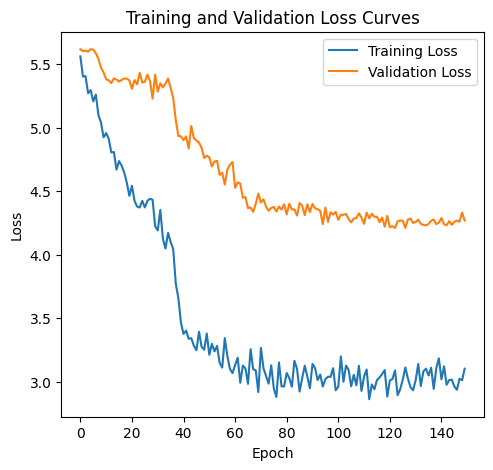

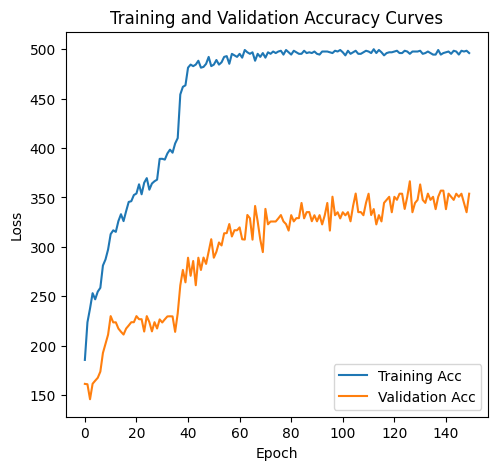

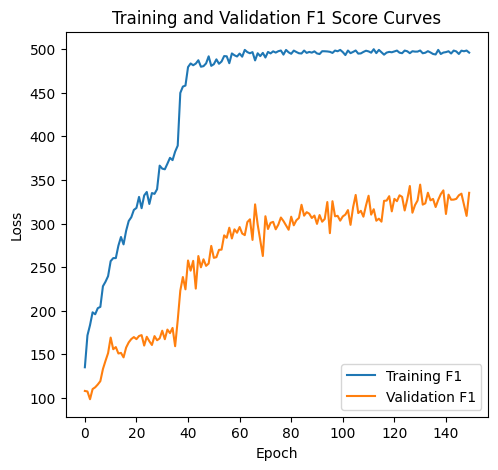

In [64]:
if __name__ == "__main__":
    main("resnet50")

# Predict Testing Data 

In [160]:
 models = {
    "vgg16": VGGplus(num_classes = 3, features_grad = True),
    "resnet50": ResNet50plus(num_classes = 3, features_grad = True)
}

In [ ]:
test_df = pd.read_csv(config.root+'/data/test.csv')
test_dataset = ParkinsonsDataset(test_df, transforms = My_transforms, mode="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [166]:
def output_vote_result(model_name):
    probs = torch.tensor([[.0]*3]*test_df.shape[0]).to(config.device)
    for i in range(5):
        model = models[model_name]
        best_ckpt = torch.load(f"{model_name}_{i}_checkpoint.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])
        pred, prob = predict(model, test_loader, config.device)
        prob = torch.cat([p for p in prob], 0)
        probs += prob
    probs /= 5.0

    predicted = []
    for i in range(test_df.shape[0]):
        predicted.append(torch.argmax(probs[i]).cpu().detach().numpy()+1)

    df_predicted = pd.DataFrame(probs.cpu().detach(), columns = ["Stage1", "Stage2", "Stage3"])
    df_predicted["Stage"] = predicted
    return df_predicted
    

In [167]:
vgg16_df_predicted = output_vote_result("vgg16")
resnet50_df_predicted = output_vote_result("resnet50")

In [171]:
vgg16_df_predicted.to_csv("VGG16.csv")
resnet50_df_predicted.to_csv("ResNet50.csv")

In [157]:
# def output_vote_result()
# probs = torch.tensor([[.0]*3]*test_df.shape[0]).to(config.device)
# for i in range(5):
#     pred, prob = predict(resnet_models[f"model{i+1}"], test_loader, config.device)
#     prob = torch.cat([p for p in prob], 0)
#     probs += prob
# probs /= 5.0

# predicted = []
# for i in range(test_df.shape[0]):
#     predicted.append(torch.argmax(probs[i]).cpu().detach().numpy())

# df_predicted = pd.DataFrame(probs.cpu().detach(), columns = ["Stage1", "Stage2", "Stage3"])
# df_predicted["Stage"] = predicted
# df_predicted

,Stage1,Stage2,Stage3,Stage
0,0.504039,0.206442,0.289519,0
1,0.163652,0.306183,0.530166,2
2,0.656496,0.289341,0.054163,0
3,0.118440,0.069757,0.811803,2
4,0.695427,0.055218,0.249355,0
5,0.003108,0.005530,0.991362,2
6,0.486108,0.426854,0.087039,0
7,0.001554,0.001461,0.996985,2
8,0.413191,0.413796,0.173012,1
9,0.660638,0.314545,0.024816,0
